Use the ratings of all movies by the user as a feature vector and process the input user ID with the KNN algorithm:  
1. Select the 10 users most similar to the current user;  
2. Identify movies that these 10 similar users have watched but the current user has not;  
3. Recommend the ten movies with the highest average ratings from these films to this user.

In [2]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357274 sha256=627aef09828ef58ecc9d4501ac90eaa925f26a2d876a101a709cadde86c61c5e
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


In [58]:
# Dependencies
import pandas as pd
import numpy as np
from surprise import Reader, Dataset, KNNBaseline
from surprise.model_selection import train_test_split
from surprise import accuracy

In [59]:
# Load the data
movies = pd.read_csv('/content/DataSets/Movies_data_V3.csv')
ratings = pd.read_csv('/content/DataSets/ratings_clean.csv')
users = pd.read_csv('/content/DataSets/users_clean_V2.csv')

# Check dataset shapes
print("Movies shape:", movies.shape)
print("Ratings shape:", ratings.shape)
print("Users shape:", users.shape)

Movies shape: (3875, 21)
Ratings shape: (1000208, 4)
Users shape: (6040, 4)


In [60]:
# Rename columns to match expected format
ratings = ratings.rename(columns={
    'UserID': 'userId',
    'MovieID': 'movieId',
    'Rating': 'rating'
})

movies = movies.rename(columns={
    'MovieID': 'movieId',
    'Title': 'title',
    'YEAR': 'year'
})

users = users.rename(columns={
    'UserID': 'userId',
    'Gender': 'gender',
    'Age': 'age',
    'Occupation': 'occupation'
})

In [61]:
# Check the columns
print(movies.columns)
print(ratings.columns)
print(users.columns)

Index(['year', 'movieId', 'title', 'Genres_Western', 'Genres_War',
       'Genres_Thriller', 'Genres_Sci-Fi', 'Genres_Romance', 'Genres_Mystery',
       'Genres_Musical', 'Genres_Horror', 'Genres_Film-Noir', 'Genres_Fantasy',
       'Genres_Drama', 'Genres_Documentary', 'Genres_Crime', 'Genres_Comedy',
       'Genres_Children's', 'Genres_Animation', 'Genres_Adventure',
       'Genres_Action'],
      dtype='object')
Index(['userId', 'movieId', 'rating', 'Timestamp'], dtype='object')
Index(['userId', 'gender', 'age', 'occupation'], dtype='object')


In [62]:
movies.dtypes

,0
year,object
movieId,int64
title,object
Genres_Western,int64
Genres_War,int64
Genres_Thriller,int64
Genres_Sci-Fi,int64
Genres_Romance,int64
Genres_Mystery,int64
Genres_Musical,int64


In [63]:
# Convert 'year' column to numeric, setting non-numeric values to NaN
movies['year'] = pd.to_numeric(movies['year'], errors='coerce')

In [64]:
movies.dtypes

,0
year,float64
movieId,int64
title,object
Genres_Western,int64
Genres_War,int64
Genres_Thriller,int64
Genres_Sci-Fi,int64
Genres_Romance,int64
Genres_Mystery,int64
Genres_Musical,int64


In [65]:
# Create the Surprise Dataset object
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

In [66]:
# Split the dataset into 85% training and 15% testing
trainset, testset = train_test_split(data, test_size=0.15)

In [67]:
# Define the function to train the KNN model
def train_knn_model(sim_option='pearson_baseline', user_based=True):
    sim_options = {'name': sim_option, 'user_based': user_based}
    algo = KNNBaseline(sim_options=sim_options)
    algo.fit(trainset)
    return algo

In [68]:
# Recommend movies based on user attributes without requiring a user ID
def recommend_movies_based_on_attributes(algo, gender, age, occupation, preferred_year, year_tolerance=5, num=10):
    """
    Recommend movies based on user demographic attributes without requiring a specific user ID.

    Parameters:
    - algo: Trained KNN model.
    - gender: The gender of the user.
    - age: The age of the user.
    - occupation: The occupation of the user.
    - preferred_year: The preferred movie release year.
    - year_tolerance: Range of years around the preferred year.
    - num: The number of movie recommendations to return.

    Returns:
    - A list of recommended movie titles and their IDs.
    """
    # Filter users with similar attributes
    similar_users_df = users[(users['gender'] == gender) &
                             (users['age'] == age) &
                             (users['occupation'] == occupation)]
    similar_user_ids = similar_users_df['userId'].values

    # Dictionary to accumulate movie ratings
    movie_ratings = {}
    for similar_user in similar_user_ids:
        similar_user_movies = ratings[ratings['userId'] == similar_user]
        for _, row in similar_user_movies.iterrows():
            movie_id, rating = row['movieId'], row['rating']
            movie_year = movies[movies['movieId'] == movie_id]['year'].values[0]

            # Check if movie is within the preferred year range
            if abs(movie_year - preferred_year) <= year_tolerance:
                if movie_id in movie_ratings:
                    movie_ratings[movie_id] += rating
                else:
                    movie_ratings[movie_id] = rating

    # Sort movies by their cumulative rating
    sorted_movies = sorted(movie_ratings.items(), key=lambda x: x[1], reverse=True)[:num]

    # Get the movie titles and years for the top recommendations
    recommended_titles = [movies[movies['movieId'] == movie_id]['title'].values[0] for movie_id, _ in sorted_movies]
    recommended_years = [movies[movies['movieId'] == movie_id]['year'].values[0] for movie_id, _ in sorted_movies]

    return list(zip(recommended_titles, recommended_years))


In [69]:
# Train the KNN model on the training set
algo = train_knn_model()

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [72]:
# Example usage: Recommend movies for a specific user with attributes and preferred year
gender = 2  # User's gender
age = 25  # User's age
occupation = 10  # User's occupation
preferred_year = 2000  # User's preferred movie release year
recommended_movies = recommend_movies_for_user(algo, user_id, gender, age, occupation, preferred_year, num=10)

In [73]:
# Output the recommended movies
print("Recommended movies based on demographic attributes:")
for title, year in recommended_movies:
    print(f"{title} ({year})")

Recommended movies based on demographic attributes:
Whole Wide World, The (1996.0)
Liar Liar (1997.0)
Nine Months (1995.0)
French Kiss (1995.0)
At First Sight (1999.0)
Man on the Moon (1999.0)
Last Man Standing (1996.0)
William Shakespeare's Romeo and Juliet (1996.0)
Con Air (1997.0)
Zero Effect (1998.0)


Model Evaluation

In [74]:
# Evaluate the model's accuracy on the test set
predictions = algo.test(testset)
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

print(f"\nModel RMSE: {rmse}")
print(f"Model MAE: {mae}")

RMSE: 0.8654
MAE:  0.6781

Model RMSE: 0.8653550714207688
Model MAE: 0.6780854307712261


RMSE: An RMSE of 0.8654 indicates that, on average, the predictions deviate by about 0.87 points from the actual ratings (on a scale of 1 to 5). For a recommendation system, an RMSE below 1.0 is generally considered reasonably accurate, though lower values (closer to 0.5) indicate a better-performing model.

MAE: An MAE of 0.6781 means that the average absolute error in predictions is around 0.68 points. This suggests that the model's predictions are, on average, within roughly 0.68 points of the actual ratings.

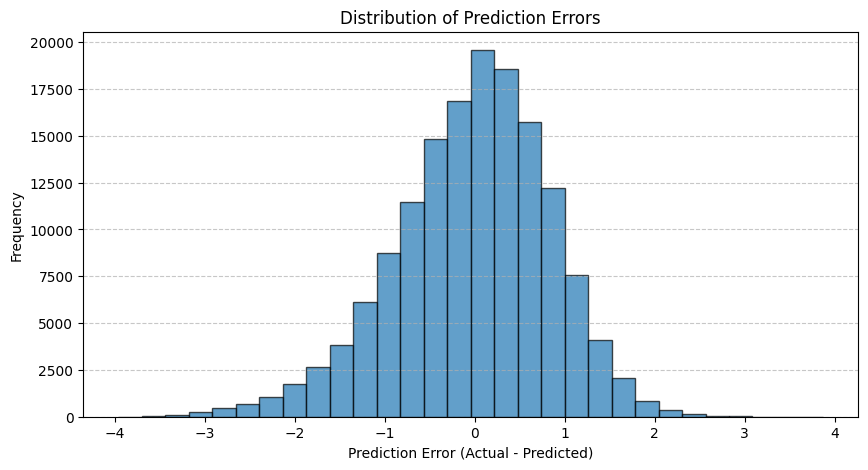

In [76]:
import matplotlib.pyplot as plt

# Extract actual ratings and predicted ratings
actual_ratings = [pred.r_ui for pred in predictions]
predicted_ratings = [pred.est for pred in predictions]
errors = [pred.r_ui - pred.est for pred in predictions]  # Prediction errors

# Plot the distribution of prediction errors
plt.figure(figsize=(10, 5))
plt.hist(errors, bins=30, edgecolor='black', alpha=0.7)
plt.title("Distribution of Prediction Errors")
plt.xlabel("Prediction Error (Actual - Predicted)")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Prediction error distribution (histogram): The histogram shows that most prediction errors are concentrated around zero, indicating that the model's predicted values are close to the actual values, and it appears to be approximately normally distributed with a slight skew. This symmetry suggests that the model does not consistently overestimate or underestimate scores.

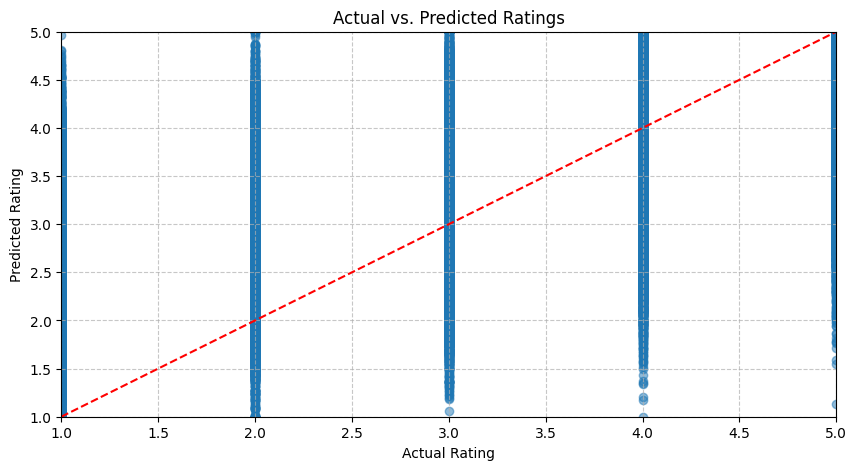

In [77]:
# Scatter plot of actual vs. predicted ratings
plt.figure(figsize=(10, 5))
plt.scatter(actual_ratings, predicted_ratings, alpha=0.5)
plt.plot([1, 5], [1, 5], 'r--')  # Reference line for perfect prediction
plt.title("Actual vs. Predicted Ratings")
plt.xlabel("Actual Rating")
plt.ylabel("Predicted Rating")
plt.xlim(1, 5)
plt.ylim(1, 5)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

### Structure of the Graph

1. **Red Dashed Line (Diagonal)**: This red dashed line represents "perfect prediction," meaning that if the model's predicted values perfectly match the actual values, all points should fall on this line. In other words, **if a point is exactly above or below the red dashed line, it indicates that the model's predicted value equals the actual value**.

2. **Blue Dots (Relationship Between Actual and Predicted Values)**: Each blue dot represents a combination of (actual score, predicted score). The horizontal axis represents actual scores, while the vertical axis represents the model's predicted scores. For example, if a point is located vertically along an x-coordinate of 3 and its y-coordinate is close to 3, it indicates that the actual score is 3 and so is the model’s prediction.

### Relationship Between Actual and Predicted Values

Since user ratings are discrete (only integers from 1 to 5), there are noticeable **vertical bands** in the graph; each actual rating (1, 2, 3, 4, 5) has a corresponding vertical band:

- **Actual Rating of 1**: If a user rates a movie as 1, ideally the model would predict closer to 1 (if accurate). However, as seen in the graph, sometimes predictions can be higher than expected—approaching even close to 3.
- **Actual Rating of 5**: Similarly, if a user's actual rating is 5, ideally their predicted value should also be near to it—close to where it meets with red line. Yet many predictions appear lower in proximity to around three.

### Why Bands Appear

These vertical bands in the graph indicate:

- **Fixed Actual Ratings**: Actual ratings can only be discrete integers from one through five; thus there are only five positions on this horizontal axis.
- **Variable Predicted Values**: Predicted scores can take continuous values—not limited strictly to integers. Therefore even when an actual rating stands at three—the model might predict values like two-point-eight or three-point-one etc.

### Summary

- **Perfect Prediction**: Points lying on top of red diagonal signify highly accurate predictions by models.
- **Deviation from Diagonal Points**: The further away points lie from this red diagonal signifies greater predictive error—for instance for an actual rating standing at five—a prediction falling at three shows significant underestimation by models regarding scoring.